Sergey Li-Zan-Men MADE

Пробовал ef2-7 и vit_b_32. Пробовал менять головы, но качество лучше чем 0.89797 на паблике не получил. Ресурсы ограниченны 30 часов в неделю на гпу кегла, поэтому очень много сабмитов (сохранял с разных эпох). Обидно не перейти за 0.9 и честно не понимаю, почему vit плохо сходился (лосс на трейне не падал ниже 3). Весь код тот же меняется только модель в основе

# Import

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output

from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score

from tqdm import tqdm

NUM_CLASSES = 30

RANDOM_SEED = 2
PATH_TO_DATA = '../input/vk-made-sports-image-classification'
PATH_TO_TRAIN_CSV = PATH_TO_DATA + '/train.csv'
PATH_TO_TEST_CSV = PATH_TO_DATA + '/test.csv'
PATH_TO_TRAIN_IMAGES = PATH_TO_DATA + '/train'
PATH_TO_TEST_IMAGES = PATH_TO_DATA + '/test'

IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
train_data = pd.read_csv(PATH_TO_TRAIN_CSV)

label2id = {}
id2label = {}
for i, label in enumerate(train_data.label.unique(), start=0):
    label2id[label] = i
    id2label[i] = label
label2id

{'swimming': 0,
 'greco-Roman_wrestling': 1,
 'running': 2,
 'football': 3,
 'sailing': 4,
 'basketball': 5,
 'fencing': 6,
 'surfing': 7,
 'alpinism': 8,
 'golf': 9,
 'water_polo': 10,
 'rugby': 11,
 'horseback_riding': 12,
 'sambo': 13,
 'hockey': 14,
 'taekwondo': 15,
 'skating': 16,
 'boating': 17,
 'ski_race': 18,
 'tennis': 19,
 'velo': 20,
 'handball': 21,
 'arm_wrestling': 22,
 'archery': 23,
 'pole_vault': 24,
 'boxing': 25,
 'volleyball': 26,
 'gymnastics': 27,
 'javelin-throwing': 28,
 'badminton': 29}

# Load data

In [3]:
# для работы с датасетом
class ImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None, target_transform=None, test=False):
        self.img_dir = img_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = label2id[self.data.iloc[idx, 1]] if not self.test else self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Вывод изображений
def show_images(dataset, n_images, test=False):
    np.random.seed(RANDOM_SEED)
    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(15, 5))

    for i in range(n_images):
        idx = np.random.randint(0, len(dataset))
        image, label_id = dataset[idx]
        class_name = id2label[label_id] if not test else label_id
        image_size = tuple(image.shape[1:])
        axes[i].imshow(image.permute(1, 2, 0), vmin=0, vmax=1)
        axes[i].set_title(f"Class: {class_name}\nSize: {image_size}")
        axes[i].axis('off')

    plt.show()

### Посмотрим на изображения и аугментации

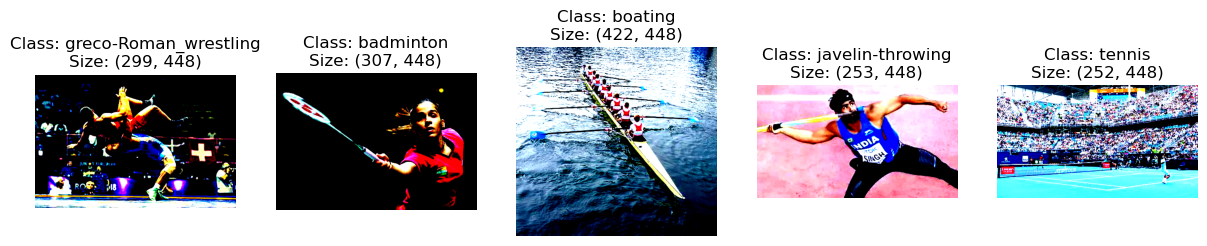

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

train_dataset = ImageDataset(PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_CSV, transform=transform)
show_images(train_dataset, 5)

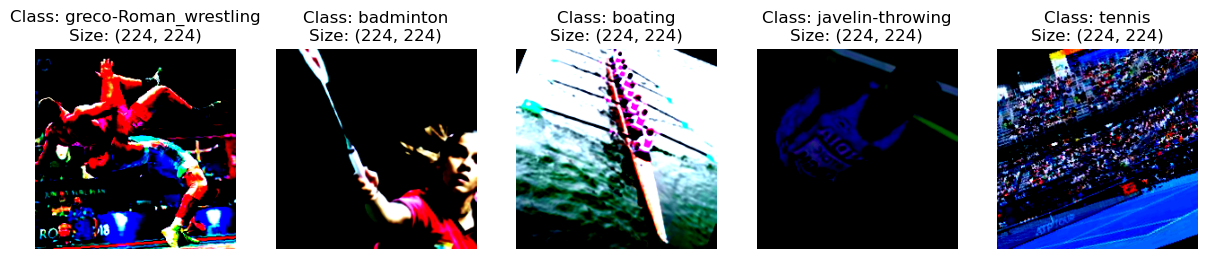

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(35),
    transforms.ColorJitter(brightness=0.6, contrast=0.4, saturation=0.6, hue=0.2),
    transforms.Resize(IMAGE_SIZE + 30), # Рессайзим до большего размера чем нужно, чтобы поубирать черные места после поворота
    transforms.CenterCrop(IMAGE_SIZE), # Берем квадрат из центра
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

all_train_dataset = ImageDataset(PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_CSV, transform=train_transforms)
show_images(all_train_dataset, 5)

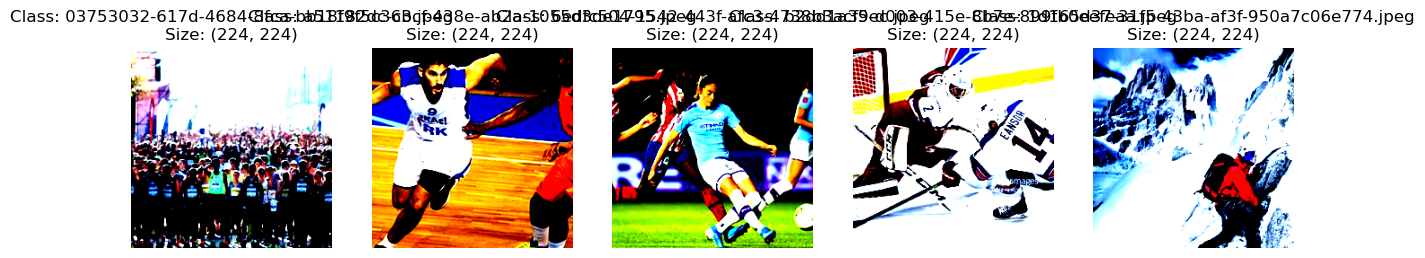

In [6]:
test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 30),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

test_dataset = ImageDataset(PATH_TO_TEST_IMAGES, PATH_TO_TEST_CSV, transform=test_transforms, test=True)
show_images(test_dataset, 5, test=True)

In [7]:
len(train_dataset)

45373

In [8]:
len(test_dataset)

19446

In [9]:
BATCH_SIZE = 512

# Разделение датасета на train и val
train_size = int(0.8 * len(all_train_dataset))
val_size = len(all_train_dataset) - train_size
train_dataset, val_dataset = random_split(all_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_SEED))

# Создание train и val DataLoader
all_train_loader = DataLoader(all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
len(train_loader), len(val_loader)

(71, 18)

# Fine tuning

In [11]:
# функция для обучения модели
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = []
    running_micro_f1 = []
    tqdm_loader = tqdm(enumerate(loader, 0), total=len(loader))
    for i, data in tqdm_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        running_loss.append(batch_loss)
        preds = torch.argmax(outputs, axis=1)
        batch_f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
        running_micro_f1.append(batch_f1)
        tqdm_loader.set_description(f"loss: {batch_loss:.3f}, F1: {batch_f1:.3f}")

    return running_loss, running_micro_f1

# функция для валидации модели
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = []
    running_micro_f1 = []
    tqdm_loader = tqdm(enumerate(loader, 0), total=len(loader))

    with torch.no_grad():
        for i, data in tqdm_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss = loss.item()
            running_loss.append(batch_loss)
            preds = torch.argmax(outputs, axis=1)
            batch_f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
            running_micro_f1.append(batch_f1)
            tqdm_loader.set_description(f"loss: {batch_loss:.3f}, F1: {batch_f1:.3f}")

    return running_loss, running_micro_f1



In [12]:
NUM_EPOCHS = 45

model = models.efficientnet_v2_m(pretrained=True)
# model = models.vit_b_32()

in_features = model.classifier[-1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, NUM_CLASSES),
)
# Замораживаем все слои кроме последнего полносвязного
for name, param in model.named_parameters():
    if name.startswith('features.8') or name.startswith('features.7') or name.startswith('classifier.') :
        param.requires_grad = True
    else:
        param.requires_grad = False

#     print(name, param.requires_grad)
    
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

Number of parameters: 52896786


In [13]:
model.load_state_dict(torch.load('/kaggle/working/model_ef2_v2_m_3l_29.pth'))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5, verbose=True)

train_loss_history = []
train_micro_f1_history = []
val_loss_history = []
val_micro_f1_history = []

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_ef2_v2_m_3l_29.pth'

In [ ]:
for epoch in range(30, NUM_EPOCHS):
    print(f"Epoch {epoch}")

    train_losses, train_micro_f1 = train(model, train_loader, criterion, optimizer, device)
    train_loss = np.mean(train_losses)
    train_f1 = np.mean(train_micro_f1)

    val_losses, val_micro_f1 = validate(model, val_loader, criterion, device)
    val_loss = np.mean(val_losses)
    val_f1 = np.mean(val_micro_f1)

    clear_output(True)

    print(f"Avg Train loss: {train_loss:.3f}, Avg Train micro F1: {train_f1:.3f}")
    
    print(f"Avg Val loss: {val_loss:.3f}, Avg Val micro F1: {val_f1:.3f}")
    scheduler.step()
    
    train_loss_history += train_losses
    train_micro_f1_history += train_micro_f1
    val_loss_history += val_losses
    val_micro_f1_history += val_micro_f1

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))

    ax1.plot(train_loss_history, label='loss')
    ax2.plot(val_loss_history, label='val loss')

    ax3.plot(train_micro_f1_history, label='f1')
    ax4.plot(val_micro_f1_history, label='val f1')

    plt.show()
    torch.save(model.state_dict(), f'model_ef2_v2_m_3l_{epoch}.pth')

    submission = pd.read_csv(PATH_TO_TEST_CSV)
    
    submission = submission.set_index('image_id')
    submission['label'] = -1

    model.eval()

    for image, pathes in tqdm(test_loader):
        image = image.to(device)
        # Вычисление предсказания
        with torch.no_grad():
            prediction = model(image)
        labels = torch.argmax(prediction, dim=1)
        for i, path in enumerate(pathes):
            submission.loc[path, 'label'] = id2label[labels[i].item()]
    submission = submission.reset_index()
    assert (submission.label == -1).sum() == 0

    submission.to_csv(f'submission_ef2_v2_m_3l_{epoch}.csv', index=False)

In [ ]:
submission = pd.read_csv(PATH_TO_TEST_CSV)
submission = submission.set_index('image_id')
submission['label'] = -1

model.eval()

for image, pathes in tqdm(test_loader):
    image = image.to(device)
    # Вычисление предсказания
    with torch.no_grad():
        prediction = model(image)
    labels = torch.argmax(prediction, dim=1)
    for i, path in enumerate(pathes):
        submission.loc[path, 'label'] = id2label[labels[i].item()]
submission = submission.reset_index()
assert (submission.label == -1).sum() == 0

submission.to_csv(f'submission_ef2_v2_m_3l_{epoch}.csv', index=False)